# Using data from AWS


A significant amount of Earth System Model (ESM) data is publicly available
online, including data from the CESM Large Ensemble, CMIP5, and CMIP6 datasets.
For accessing a single file, we can specify the file (typically netcdf or zarr
format) and its location and then use fsspec (the "Filesystem Spec+ python
package) and xarray to create a array.dataset. For several files, the intake_esm
python module (https://github.com/intake/intake-esm) is particularly nice for
obtaining the data and put it into an xarray.dataset.

This notebook assumes familiarity with the Tutorial Notebook. It additionally
shows how to gather data from an ESM collection, put it into a dataset, and then
create simple plots using the data with ldcpy.

#### Example Data

The example data we use is from the CESM Large Ensemble, member 31. This
ensemble data has been lossily compressed and reconstructed as part of a blind
evaluation study of lossy data compression in LENS (e.g.,
http://www.cesm.ucar.edu/projects/community-projects/LENS/projects/lossy-data-compression.html
or https://gmd.copernicus.org/articles/9/4381/2016/).

Most of the data from the CESM Large Ensemble Project has been made available on
Amazon Web Services (Amazon S3), see
http://ncar-aws-www.s3-website-us-west-2.amazonaws.com/CESM_LENS_on_AWS.htm .

For comparison purposes, the original (non-compressed) data for Ensemble 31 has
recently been made available on Amazon Web Services (Amazon S3) in the
"ncar-cesm-lens-baker-lossy-compression-test" bucket.


In [1]:
# Add ldcpy root to system path
import sys

sys.path.insert(0, '../../../')

# Import ldcpy package
# Autoreloads package everytime the package is called, so changes to code will be reflected in the notebook if the above sys.path.insert(...) line is uncommented.
%load_ext autoreload
%autoreload 2
import fsspec
import intake
import xarray as xr

import ldcpy

# display the plots in this notebook
%matplotlib inline

# silence warnings
import warnings

warnings.filterwarnings("ignore")

## Method 1: using fsspec and xr.open_zarr


First, specify the filesystem and location of the data. Here we are accessing
the original data from CESM-LENS ensemble 31, which is available on Amazon S3 in
the store named _"ncar-cesm-lens-baker-lossy-compression-test"_ bucket.

First we listing all available files (which are timeseries files containing a
single variable) for that dataset. Note that unlike in the TutorialNotebook
(which used NetCDF files), these files are all zarr format. Both monthly and
daily data is available.


In [2]:
fs = fsspec.filesystem("s3", anon=True)
stores = fs.ls("ncar-cesm-lens-baker-lossy-compression-test/lens-ens31/")[1:]
stores[:]

['ncar-cesm-lens-baker-lossy-compression-test/lens-ens31/cesmle-atm-ens31-20C-daily-FLNS.zarr',
 'ncar-cesm-lens-baker-lossy-compression-test/lens-ens31/cesmle-atm-ens31-20C-daily-FLNSC.zarr',
 'ncar-cesm-lens-baker-lossy-compression-test/lens-ens31/cesmle-atm-ens31-20C-daily-FLUT.zarr',
 'ncar-cesm-lens-baker-lossy-compression-test/lens-ens31/cesmle-atm-ens31-20C-daily-FSNS.zarr',
 'ncar-cesm-lens-baker-lossy-compression-test/lens-ens31/cesmle-atm-ens31-20C-daily-FSNSC.zarr',
 'ncar-cesm-lens-baker-lossy-compression-test/lens-ens31/cesmle-atm-ens31-20C-daily-FSNTOA.zarr',
 'ncar-cesm-lens-baker-lossy-compression-test/lens-ens31/cesmle-atm-ens31-20C-daily-ICEFRAC.zarr',
 'ncar-cesm-lens-baker-lossy-compression-test/lens-ens31/cesmle-atm-ens31-20C-daily-LHFLX.zarr',
 'ncar-cesm-lens-baker-lossy-compression-test/lens-ens31/cesmle-atm-ens31-20C-daily-PRECL.zarr',
 'ncar-cesm-lens-baker-lossy-compression-test/lens-ens31/cesmle-atm-ens31-20C-daily-PRECSC.zarr',
 'ncar-cesm-lens-baker-lossy-

Then we select the file from the store that we want and open it as an
xarray.Dataset using xr.open_zarr(). Here we grab data for the first 2D daily
variable, FLNS (net longwave flux at surface, in $W/m^2$), in the list (accessed
by it location -- stores[0]).


In [3]:
store = fs.get_mapper(stores[0])
ds_flns = xr.open_zarr(store, consolidated=True)
ds_flns

<xarray.Dataset>
Dimensions:    (lat: 192, lon: 288, nbnd: 2, time: 31390)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) object 1920-01-01 12:00:00 ... 2005-12-31 12:00:00
    time_bnds  (time, nbnd) object dask.array<chunksize=(15695, 2), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    FLNS       (time, lat, lon) float32 dask.array<chunksize=(576, 192, 288), meta=np.ndarray>
Attributes:
    Conventions:      CF-1.0
    NCO:              netCDF Operators version 4.7.9 (Homepage = http://nco.s...
    Version:          $Name$
    case:             b.e11.B20TRC5CNBDRD.f09_g16.031
    host:             ys0219
    initial_file:     b.e11.B20TRC5CNBDRD.f09_g16.001.cam.i.1920-01-01-00000.nc
    logname:          mickelso
    revision_Id:      $Id$
    source:           CAM
    title:            UNSET
    topography_file:  /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/USGS-gtop...

The above returned an xarray.Dataset.

Now let's grab the TMQ (Total vertically integrated precipitatable water) and
the TS (surface temperature data) and PRECT (precipitation rate) data from AWS.


In [4]:
# TMQ data
store2 = fs.get_mapper(stores[16])
ds_tmq = xr.open_zarr(store2, consolidated=True)
# TS data
store3 = fs.get_mapper(stores[20])
ds_ts = xr.open_zarr(store3, consolidated=True)
# PRECT data
store4 = fs.get_mapper(stores[11])
ds_prect = xr.open_zarr(store4, consolidated=True)

Now we have the original data for FLNS and TMQ and TS and PRECT. Next we want to
get the lossy compressed variants to compare with these.


## Method 2: Using intake_esm


Now we will demonstrate using the intake_esm module to get the lossy variants of
the files retrieved above. We can use the intake_esm module to search for and
open several files as xarray.Dataset objects. The code below is modified from
the intake_esm documentation, available here:
https://intake-esm.readthedocs.io/en/latest/?badge=latest#overview.


We want to use ensemble 31 data from the CESM-LENS collection on AWS, which (as
explained above) has been subjected to lossy compression. Many catalogs for
publicly available datasets are accessible via intake-esm can be found at
https://github.com/NCAR/intake-esm-datastore/tree/master/catalogs, including for
CESM-LENS. We can open that collection as follows (see here:
https://github.com/NCAR/esm-collection-spec/blob/master/collection-spec/collection-spec.md#attribute-object):


In [5]:
aws_loc = (
    "https://raw.githubusercontent.com/NCAR/cesm-lens-aws/master/intake-catalogs/aws-cesm1-le.json"
)
aws_col = intake.open_esm_datastore(aws_loc)
aws_col

,unique
variable,77
long_name,74
component,5
experiment,4
frequency,6
vertical_levels,3
spatial_domain,5
units,25
start_time,12
end_time,13


Next, we search for the subset of the collection (dataset and variables) that we
are interested in. Let's grab FLNS, TMQ, and TS daily data from the atm
component for our comparison (available data in this collection is listed here:
http://ncar-aws-www.s3-website-us-west-2.amazonaws.com/CESM_LENS_on_AWS.htm).


In [6]:
# we want daily data for FLNS, TMQ, and TS and PRECT
aws_col_subset = aws_col.search(
    component="atm",
    frequency="daily",
    experiment="20C",
    variable=["FLNS", "TS", "TMQ", "PRECT"],
)
# display header info to verify that we got the right variables
aws_col_subset.df.head()

,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,FLNS,net longwave flux at surface,atm,20C,daily,1.0,global,W/m2,1920-01-01 12:00:00,2005-12-31 12:00:00,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-FLNS....
1,PRECT,total (convective and large-scale) precipitati...,atm,20C,daily,1.0,global,m/s,1920-01-01 12:00:00,2005-12-31 12:00:00,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-PRECT...
2,TMQ,total (vertically integrated) precipitable water,atm,20C,daily,1.0,global,kg/m2,1920-01-01 12:00:00,2005-12-31 12:00:00,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-TMQ.zarr
3,TS,surface temperature (radiative),atm,20C,daily,1.0,global,K,1920-01-01 12:00:00,2005-12-31 12:00:00,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-TS.zarr


Then we load matching catalog entries into xarray datasets
(https://intake-esm.readthedocs.io/en/latest/api.html#intake_esm.core.esm_datastore.to_dataset_dict).
We create a dictionary of datasets:


In [7]:
dset_dict = aws_col_subset.to_dataset_dict(
    zarr_kwargs={"consolidated": True, "decode_times": True},
    storage_options={"anon": True},
    cdf_kwargs={"chunks": {}, "decode_times": False},
)
dset_dict


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'


{'atm.20C.daily': <xarray.Dataset>
 Dimensions:    (lat: 192, lon: 288, member_id: 40, time: 31390)
 Coordinates:
   * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
   * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
   * member_id  (member_id) int64 1 2 3 4 5 6 7 8 ... 34 35 101 102 103 104 105
   * time       (time) object 1920-01-01 12:00:00 ... 2005-12-31 12:00:00
 Data variables:
     FLNS       (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 576, 192, 288), meta=np.ndarray>
     PRECT      (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 576, 192, 288), meta=np.ndarray>
     TMQ        (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 576, 192, 288), meta=np.ndarray>
     TS         (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 576, 192, 288), meta=np.ndarray>
 Attributes:
     intake_esm_varname:        FLNS\nPRECT\nTMQ\nTS
     initial_file:              b.e11.B20TRC5CNBDRD

Check the dataset keys to ensure that what we want is present. Here we only have
oneentry in the dictonary as we requested the same time period and output
frequency for all variables:


In [8]:
dset_dict.keys()

dict_keys(['atm.20C.daily'])

Finally, put the dataset that we are interested from the dictionary into its own
dataset variable. (We want the 20th century daily data -- which is our only
option.)

Also note from above that there are 40 ensemble members - and we just want
ensemble 31 (member_id = 30 as can be seen in the coordinates above).


In [9]:
aws_ds = dset_dict["atm.20C.daily"]
aws_ds = aws_ds.isel(member_id=30)
aws_ds

<xarray.Dataset>
Dimensions:    (lat: 192, lon: 288, time: 31390)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member_id  int64 31
  * time       (time) object 1920-01-01 12:00:00 ... 2005-12-31 12:00:00
Data variables:
    FLNS       (time, lat, lon) float32 dask.array<chunksize=(576, 192, 288), meta=np.ndarray>
    PRECT      (time, lat, lon) float32 dask.array<chunksize=(576, 192, 288), meta=np.ndarray>
    TMQ        (time, lat, lon) float32 dask.array<chunksize=(576, 192, 288), meta=np.ndarray>
    TS         (time, lat, lon) float32 dask.array<chunksize=(576, 192, 288), meta=np.ndarray>
Attributes:
    intake_esm_varname:        FLNS\nPRECT\nTMQ\nTS
    initial_file:              b.e11.B20TRC5CNBDRD.f09_g16.001.cam.i.1920-01-...
    revision_Id:               $Id$
    logname:                   mudryk
    important_note:            This data is part of the project 'Blind Evalua...
    Conventions:               CF-1.0
    NCO:                       4.4.2
    topography_file:           /scratch/p/pjk/mudryk/cesm1_1_2_LENS/inputdata...
    Version:                   $Name$
    nco_openmp_thread_number:  1
    source:                    CAM
    title:                     UNSET
    intake_esm_dataset_key:    atm.20C.daily

Now we have datasets for the original and the lossy compressed data for FLNS,
TMQ, PRECT, and TS, which we can extract into a dataset for each variable:


In [10]:
# extract the three variables from aws_ds as datasets
aws_flns = aws_ds["FLNS"].to_dataset()
aws_tmq = aws_ds["TMQ"].to_dataset()
aws_ts = aws_ds["TS"].to_dataset()
aws_prect = aws_ds["PRECT"].to_dataset()

# Use _ldcpy_ to compare the original data to the lossy compressed data


To use ldcpy, we need to group the data that we want to compare (like variables)
into dataset collections. In the Tutorial Notebook, we used
ldcpy.open_datasets() to do this as we needed to get the data from the NetCDF
files. Here we already loaded the data from AWS into datasets, so we just need
to use ldcpy.collect_datasets() to form collections of the datasets that we want
to compare.

ldcpy.collect_datasets() requires the following three arguments:

- _varnames_ : the variable(s) of interest to combine across files (typically
  the timeseries file variable name)
- _list_of_ds_ : a list of the xarray datasets
- _labels_ : a corresponding list of names (or labels) for each dataset in the
  collection

Note: This function is a wrapper for xarray.concat(), and any additional
key/value pairs passed in as a dictionary are used as arguments to
xarray.concat().

We will create 4 collections for ldcpy (one each for FLNS, TMQ, PRECT, and TS)
and assign labels "original" and "lossy" to the respective datasets.


In [11]:
# FLNS collection
col_flns = ldcpy.collect_datasets(["FLNS"], [ds_flns, aws_flns], ["original", "lossy"])
col_flns

dataset size in GB 27.63



,Array,Chunk
Bytes,27.63 GB,253.48 MB
Shape,"(2, 31390, 382, 288)","(1, 576, 382, 288)"
Count,3198 Tasks,110 Chunks
Type,float32,numpy.ndarray


In [12]:
# TMQ collection
col_tmq = ldcpy.collect_datasets(["TMQ"], [ds_tmq, aws_tmq], ["original", "lossy"])

dataset size in GB 27.63



In [13]:
# Ts collection
col_ts = ldcpy.collect_datasets(["TS"], [ds_ts, aws_ts], ["original", "lossy"])

dataset size in GB 27.63



In [14]:
# PRECT collection
col_prect = ldcpy.collect_datasets(["PRECT"], [ds_prect, aws_prect], ["original", "lossy"])

dataset size in GB 27.63



Now that we have our collections, we can do some comparisons. Note that these
are large files, so make sure you have sufficient compute/memory.


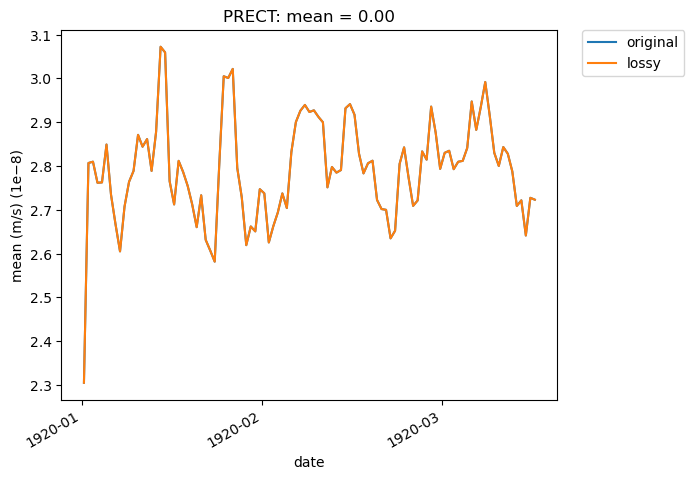

In [15]:
# Time-series plot of PRECT mean in col_ds 'original' dataset - first 100 daysa
ldcpy.plot(
    col_prect,
    "PRECT",
    sets=["original", "lossy"],
    calc="mean",
    plot_type="time_series",
    start=0,
    end=100,
)

In [16]:
# print statistics about 'original', 'lossy', and diff between the two datasets for TMQ at time slice 365
ldcpy.compare_stats(col_tmq.isel(time=365), "TMQ", ["original", "lossy"])

,original,lossy
mean,16.586,16.541
variance,239.68,238.4
standard deviation,15.482,15.44
min value,71.03,71
max value,0.28534,0.28516
probability positive,1,1
number of zeros,0,0


,lossy
max abs diff,0.0073329
min abs diff,0.0020776
mean abs diff,0.0047053
mean squared diff,2.2139e-05
root mean squared diff,0.0053893
normalized root mean squared diff,7.6178e-05
normalized max pointwise error,0.00010365
pearson correlation coefficient,0.99768
ks p-value,0.57187
spatial relative error(% > 0.0001),98.116


## Make your own catalog for intake-esm


The original data for FLNS and TMQ and TS and PRECT (from Amazon S3 in the
"ncar-cesm-lens-baker-lossy-compression-test" bucket) was loaded above using
method 1. An alternative would be to create our own catalog for this data for
use with intake-esm. To illustrate this, we created a test_catalog.csv and
test_collection.json file for this particular simple example.


We first open our collection.


In [17]:
my_col_loc = "./collections/test_collection.json"
my_col = intake.open_esm_datastore(my_col_loc)
my_col

,unique
component,1
frequency,1
experiment,1
variable,4
path,4


In [18]:
# printing the head() gives us the file names
my_col.df.head()

,component,frequency,experiment,variable,path
0,atm,daily,20C,TS,s3://ncar-cesm-lens-baker-lossy-compression-te...
1,atm,daily,20C,PRECT,s3://ncar-cesm-lens-baker-lossy-compression-te...
2,atm,daily,20C,FLNS,s3://ncar-cesm-lens-baker-lossy-compression-te...
3,atm,daily,20C,TMQ,s3://ncar-cesm-lens-baker-lossy-compression-te...


Let's load all of these into our dictionary! (So we don't need to do the search
to make a subset of variables as above in Method 2.)


In [19]:
my_dset_dict = my_col.to_dataset_dict(
    zarr_kwargs={"consolidated": True, "decode_times": True},
    storage_options={"anon": True},
)
my_dset_dict


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'


{'atm.20C.daily': <xarray.Dataset>
 Dimensions:    (lat: 192, lon: 288, nbnd: 2, time: 31390)
 Coordinates:
   * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
   * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
   * time       (time) object 1920-01-01 12:00:00 ... 2005-12-31 12:00:00
     time_bnds  (time, nbnd) object dask.array<chunksize=(15695, 2), meta=np.ndarray>
 Dimensions without coordinates: nbnd
 Data variables:
     TS         (time, lat, lon) float32 dask.array<chunksize=(576, 192, 288), meta=np.ndarray>
     PRECT      (time, lat, lon) float32 dask.array<chunksize=(576, 192, 288), meta=np.ndarray>
     FLNS       (time, lat, lon) float32 dask.array<chunksize=(576, 192, 288), meta=np.ndarray>
     TMQ        (time, lat, lon) float32 dask.array<chunksize=(576, 192, 288), meta=np.ndarray>
 Attributes:
     intake_esm_varname:      TS\nPRECT\nFLNS\nTMQ
     initial_file:            b.e11.B20TRC5CNBDRD.f09_g16.001.cam.i.192

In [20]:
# we again just want the 20th century daily data
my_ds = my_dset_dict["atm.20C.daily"]
my_ds

<xarray.Dataset>
Dimensions:    (lat: 192, lon: 288, nbnd: 2, time: 31390)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) object 1920-01-01 12:00:00 ... 2005-12-31 12:00:00
    time_bnds  (time, nbnd) object dask.array<chunksize=(15695, 2), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    TS         (time, lat, lon) float32 dask.array<chunksize=(576, 192, 288), meta=np.ndarray>
    PRECT      (time, lat, lon) float32 dask.array<chunksize=(576, 192, 288), meta=np.ndarray>
    FLNS       (time, lat, lon) float32 dask.array<chunksize=(576, 192, 288), meta=np.ndarray>
    TMQ        (time, lat, lon) float32 dask.array<chunksize=(576, 192, 288), meta=np.ndarray>
Attributes:
    intake_esm_varname:      TS\nPRECT\nFLNS\nTMQ
    initial_file:            b.e11.B20TRC5CNBDRD.f09_g16.001.cam.i.1920-01-01...
    revision_Id:             $Id$
    logname:                 mickelso
    Conventions:             CF-1.0
    NCO:                     netCDF Operators version 4.7.9 (Homepage = http:...
    topography_file:         /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/US...
    Version:                 $Name$
    case:                    b.e11.B20TRC5CNBDRD.f09_g16.031
    source:                  CAM
    host:                    ys0219
    title:                   UNSET
    intake_esm_dataset_key:  atm.20C.daily

Now we can make a dataset for each variable as before.


In [21]:
my_ts = my_ds["TS"].to_dataset()
my_tmq = my_ds["TMQ"].to_dataset()
my_prect = my_ds["PRECT"].to_dataset()
my_flns = my_ds["FLNS"].to_dataset()

And now we can form new collections as before and do comparisons...
